In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import re
from textblob import TextBlob
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist, ngrams
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from sklearn.feature_extraction.text import CountVectorizer
import nltk

In [ ]:
# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

True

### Descriptive Statistics

In [31]:
df = pd.read_csv('../data/raw_analyst_ratings.csv')

In [22]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [23]:
df = df.drop(columns=['Unnamed: 0'])

In [24]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 1. Basic statistics for headline lengths
df['headline_length'] = df['headline'].apply(len)
headline_stats = df['headline_length'].describe()
print("Headline Length Statistics:")
print(headline_stats)




Headline Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


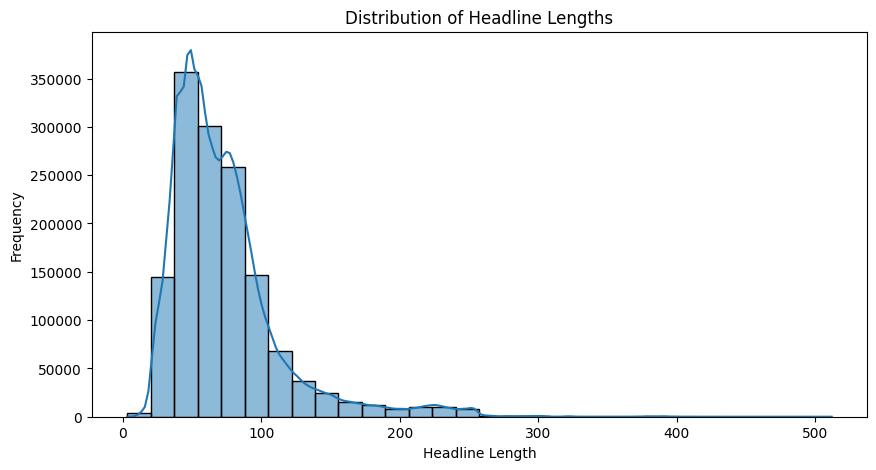

In [25]:
# Plot distribution of headline lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['headline_length'], bins=30, kde=True)
plt.title("Distribution of Headline Lengths")
plt.xlabel("Headline Length")
plt.ylabel("Frequency")
plt.show()

In [26]:
# 2. Count the number of articles per publisher
publisher_counts = df['publisher'].value_counts()
print("\nNumber of Articles per Publisher:")
print(publisher_counts)



Number of Articles per Publisher:
publisher
Paul Quintaro                      228373
Lisa Levin                         186979
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


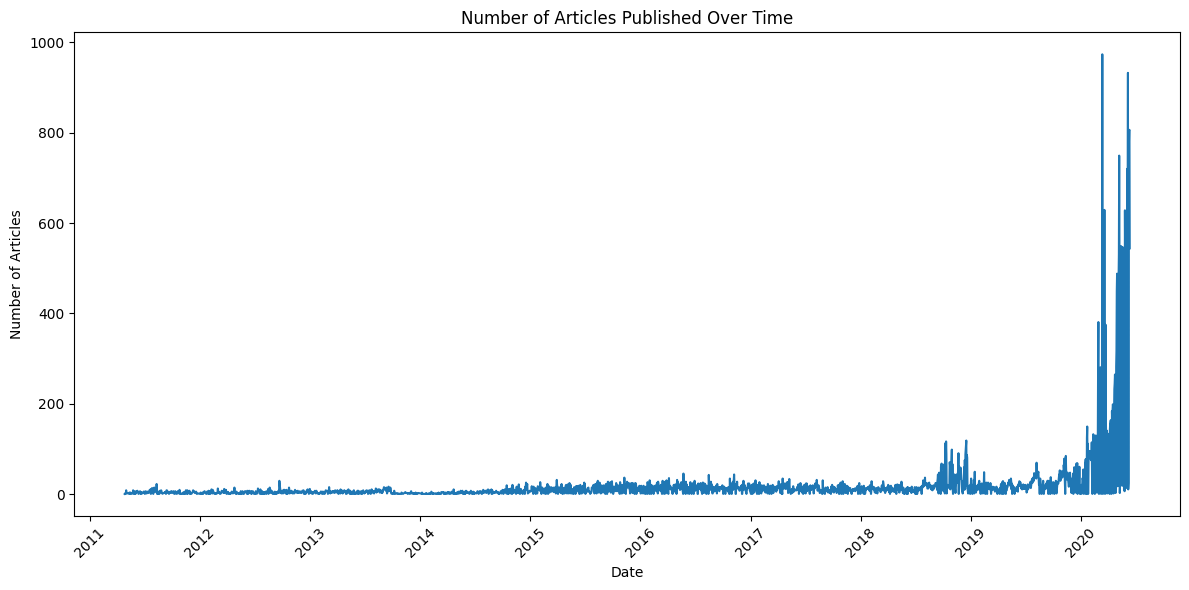

In [27]:
# 3. Analyze publication dates over time
# Extract date without time
df['date_only'] = df['date'].dt.date

# Count articles per date
articles_per_day = df['date_only'].value_counts().sort_index()

# Plot articles over time
plt.figure(figsize=(12, 6))
articles_per_day.plot()
plt.title("Number of Articles Published Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- See trend by weekday

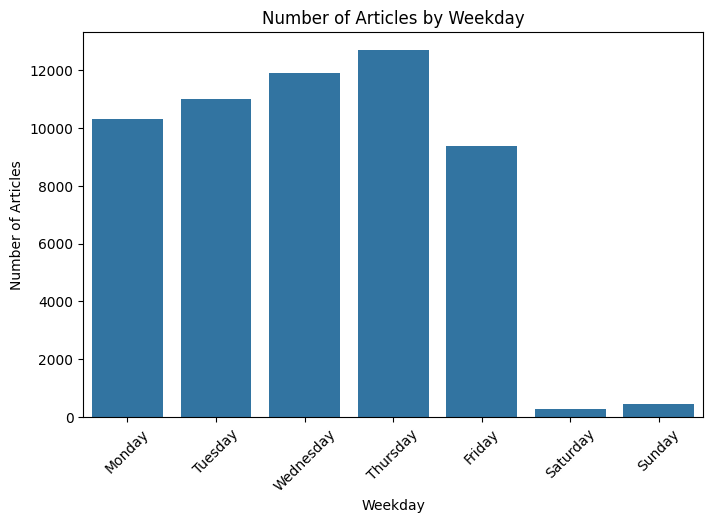

In [28]:

df['weekday'] = df['date'].dt.day_name()
weekday_counts = df['weekday'].value_counts().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])

plt.figure(figsize=(8, 5))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values)
plt.title("Number of Articles by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.show()

### Text Analysis(Topic Modeling)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hanna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Top Keywords:
         term   count
49         vs  162061
41     stocks  161869
12        est  140578
11        eps  128910
39     shares  114182
34    reports  108705
46     update   91680
20     market   90880
9    earnings   87189
35      sales   79524
44        top   78648
28         pt   73043
1   announces   66528
26      price   64233
5         buy   64059


<Figure size 1200x800 with 0 Axes>

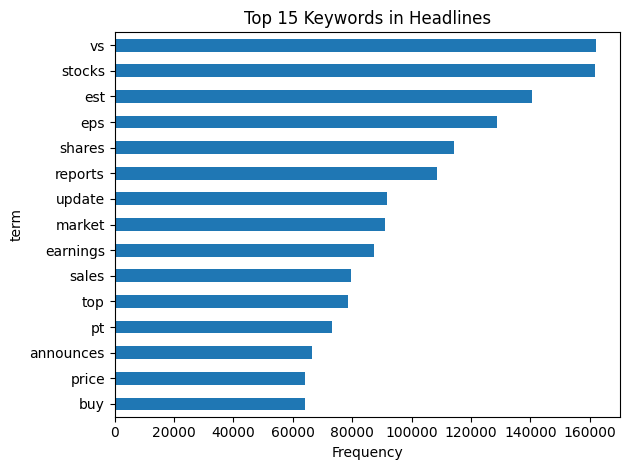


Significant Topics:

Keyword: vs (Count: 162061)
  Example 1: Agilent Reaffirms FY20 Guidance: Adj. EPS $3.38-$3.43 vs $3.42 Estimate, Sales $5.5B-$5.55B vs $5.54B Est.
  Example 2: Agilent Sees FY20 Adj. EPS $3.38-$3.43 vs $3.44 Estimate, Sales $5.5B-$5.55B vs $5.55B Est.
  Example 3: Agilent Sees Q1 Adj. EPS $0.80-$0.81 vs $0.84 Estimate, Sales $1.34B-$1.355B vs $1.38B Est.

Keyword: stocks (Count: 161869)
  Example 1: Stocks That Hit 52-Week Highs On Friday
  Example 2: Stocks That Hit 52-Week Highs On Wednesday
  Example 3: 46 Stocks Moving In Friday's Mid-Day Session

Keyword: est (Count: 140578)
  Example 1: 71 Biggest Movers From Friday
  Example 2: 10 Biggest Price Target Changes For Friday
  Example 3: Agilent Technologies Q2 Adj. EPS $0.71 Beats $0.61 Estimate, Sales $1.24B Beat $1.21B Estimate

Keyword: eps (Count: 128910)
  Example 1: Agilent Technologies shares are trading higher after the company reported better-than-expected Q2 EPS and sales results.
  Example 2: Agilen

In [ ]:
# Enhanced preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Basic cleaning
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Apply preprocessing
df['cleaned_headline'] = df['headline'].apply(preprocess_text)

# Get stopwords and extend with custom terms
nltk_stopwords = stopwords.words('english')
custom_stopwords = ['said', 'says', 'new', 'breaking']  # Add domain-specific stopwords
stopwords_extended = set(nltk_stopwords + custom_stopwords)

# Initialize CountVectorizer with advanced parameters
vectorizer = CountVectorizer(
    stop_words=list(stopwords_extended),
    max_features=50,  # Increase to get more terms
    ngram_range=(1, 3),  # Get unigrams, bigrams, and trigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)

# Create document-term matrix
X = vectorizer.fit_transform(df['cleaned_headline'])

# Get terms and their counts
terms = vectorizer.get_feature_names_out()
counts = X.sum(axis=0).A1  # Convert to 1D array

# Create keyword DataFrame
keywords_df = pd.DataFrame({'term': terms, 'count': counts})
keywords_df = keywords_df.sort_values('count', ascending=False)

# Display top keywords
print("Top Keywords:")
print(keywords_df.head(15))



In [ ]:
# Visualize results
plt.figure(figsize=(12, 8))
keywords_df.head(15).sort_values('count').plot.barh(x='term', y='count', legend=False)
plt.title('Top 15 Keywords in Headlines')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()


In [ ]:

# Extract significant topics
def extract_topics(keywords_df, n=5):
    topics = []
    for term in keywords_df['term'].head(n):
        # Find headlines containing this term
        related = df[df['cleaned_headline'].str.contains(term)]['headline'].tolist()
        topics.append({
            'keyword': term,
            'count': keywords_df[keywords_df['term'] == term]['count'].values[0],
            'example_headlines': related[:3]  # Show up to 3 examples
        })
    return topics

# Get topics with examples
topics = extract_topics(keywords_df)
print("\nSignificant Topics:")
for topic in topics:
    print(f"\nKeyword: {topic['keyword']} (Count: {topic['count']})")
    for i, headline in enumerate(topic['example_headlines'], 1):
        print(f"  Example {i}: {headline}")

### Time Series Analysis:

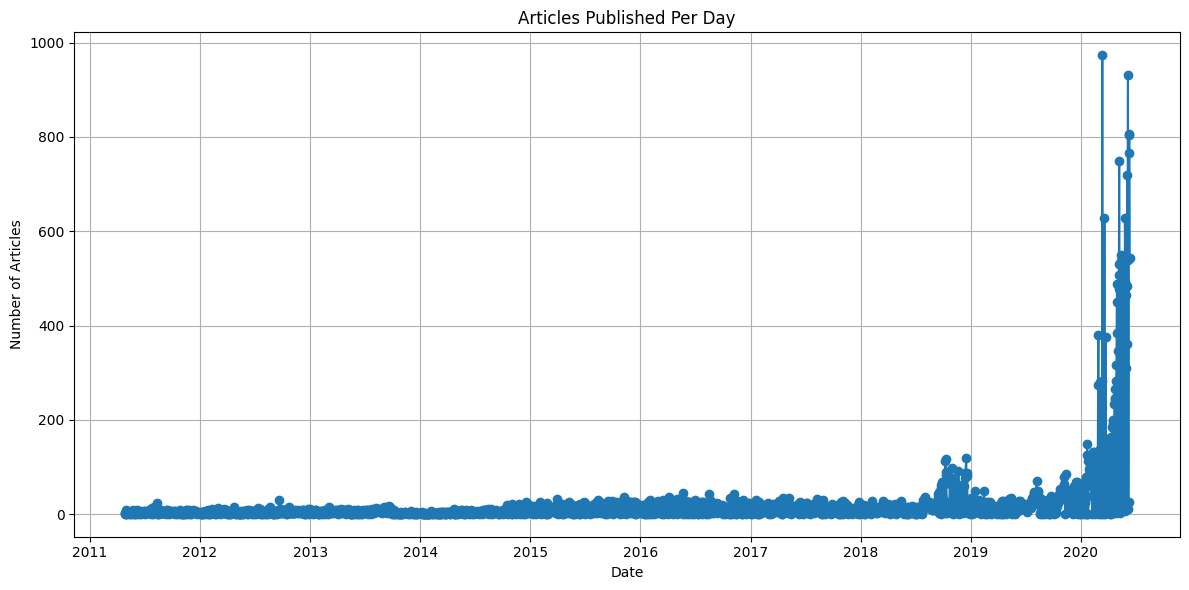

In [20]:
df['date_only'] = df['date'].dt.date

# Count articles per day
daily_counts = df.groupby('date_only').size()

# Plot time series
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', marker='o')
plt.title("Articles Published Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
threshold = daily_counts.mean() + 2 * daily_counts.std()
spikes = daily_counts[daily_counts > threshold]

print("Spikes in Article Volume:")
print(spikes)

Spikes in Article Volume:
date_only
2020-02-27    275
2020-02-28    381
2020-03-06    281
2020-03-11    282
2020-03-12    973
2020-03-19    629
2020-03-23    375
2020-03-24    160
2020-04-09    164
2020-04-13    184
2020-04-15    186
2020-04-16    199
2020-04-17    194
2020-04-20    180
2020-04-21    233
2020-04-22    245
2020-04-23    265
2020-04-24    246
2020-04-27    283
2020-04-28    317
2020-04-29    449
2020-04-30    488
2020-05-01    385
2020-05-04    347
2020-05-05    478
2020-05-06    531
2020-05-07    749
2020-05-08    508
2020-05-11    485
2020-05-12    387
2020-05-13    549
2020-05-14    536
2020-05-15    322
2020-05-18    547
2020-05-19    332
2020-05-20    461
2020-05-21    333
2020-05-22    286
2020-05-26    628
2020-05-27    492
2020-05-28    465
2020-05-29    309
2020-06-01    484
2020-06-02    361
2020-06-03    720
2020-06-04    538
2020-06-05    932
2020-06-08    765
2020-06-09    804
2020-06-10    806
2020-06-11    544
dtype: int64


In [22]:
spike_dates = spikes.index
spike_articles = df[df['date_only'].isin(spike_dates)][['date', 'headline']]
print(spike_articles)

                             date  \
0       2020-06-05 10:30:54-04:00   
1       2020-06-03 10:45:20-04:00   
2       2020-05-26 04:30:07-04:00   
3       2020-05-22 12:45:06-04:00   
4       2020-05-22 11:38:59-04:00   
...                           ...   
1406311 2020-06-04 16:07:40-04:00   
1406312 2020-06-04 04:47:06-04:00   
1406313 2020-05-27 13:00:58-04:00   
1406314 2020-05-21 10:24:22-04:00   
1406315 2020-04-13 10:01:37-04:00   

                                                  headline  
0                  Stocks That Hit 52-Week Highs On Friday  
1               Stocks That Hit 52-Week Highs On Wednesday  
2                            71 Biggest Movers From Friday  
3             46 Stocks Moving In Friday's Mid-Day Session  
4        B of A Securities Maintains Neutral on Agilent...  
...                                                    ...  
1406311  Zumiez Q1 EPS $(0.84) Misses $(0.43) Estimate,...  
1406312                Earnings Scheduled For June 4, 2020  
140631

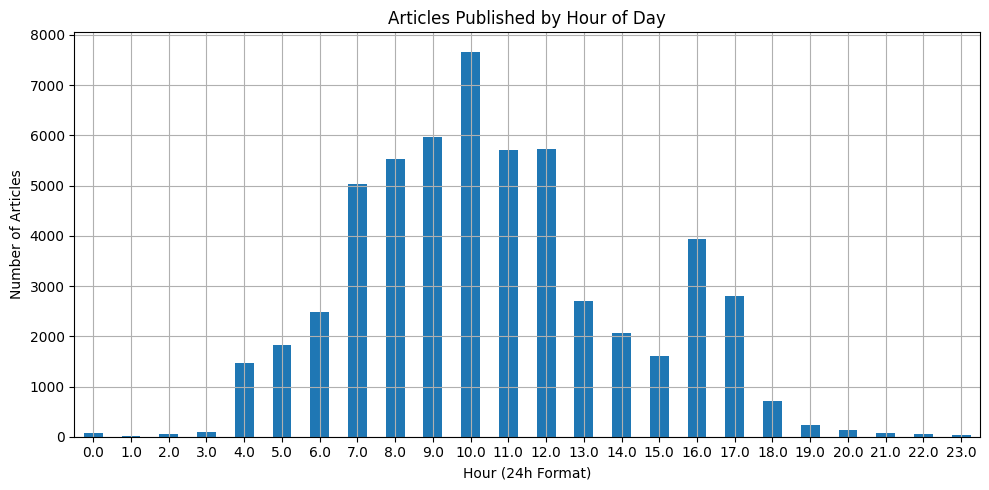

In [23]:
df['hour'] = df['date'].dt.hour

# Count articles per hour of day
hourly_counts = df['hour'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
hourly_counts.plot(kind='bar')
plt.title("Articles Published by Hour of Day")
plt.xlabel("Hour (24h Format)")
plt.ylabel("Number of Articles")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

### Publisher Analysis

Top Publishers:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


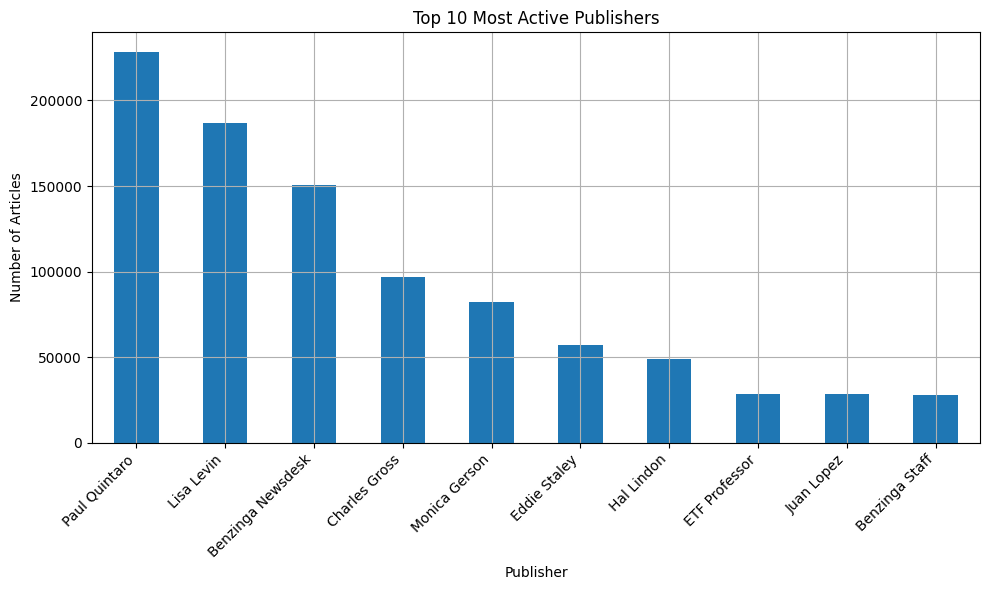

In [24]:
publisher_counts = df['publisher'].value_counts()

# Display top N (e.g., 10)
print("Top Publishers:")
print(publisher_counts.head(10))

# Optional: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
publisher_counts.head(10).plot(kind='bar')
plt.title("Top 10 Most Active Publishers")
plt.xlabel("Publisher")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

In [25]:
# Group by publisher and join their headlines
publisher_headlines = df.groupby('publisher')['headline'].apply(lambda x: ' '.join(x)).reset_index()

# Example: Show headlines for top 3 publishers
for publisher in publisher_counts.head(3).index:
    print(f"\nSample headlines from {publisher}:\n")
    print(df[df['publisher'] == publisher]['headline'].head(5).to_string(index=False))


Sample headlines from Paul Quintaro:

Agilent Reports Purchase Of Genohm, No Terms Di...
UPDATE: Alnylam, Agilent Deal Has Initial Term ...
Alnylam Pharma 8-K Shows Co. Entered Manufactur...
Agilent Reports Purchase Of Luxcel Biosciences,...
Agilent Sees Q1 Adj. EPS $0.55-$0.57 vs $0.60 E...

Sample headlines from Lisa Levin:

                  71 Biggest Movers From Friday
   46 Stocks Moving In Friday's Mid-Day Session
     10 Biggest Price Target Changes For Friday
30 Stocks Moving in Friday's Pre-Market Session
            Earnings Scheduled For May 21, 2020

Sample headlines from Benzinga Newsdesk:

Agilent Technologies shares are trading higher ...
Agilent Technologies shares are trading higher ...
Agilent Technologies Q2 Adj. EPS $0.71 Beats $0...
Pershing Square 13F Shows Fund Raises Stake In ...
Shares of several healthcare companies are trad...


In [ ]:


# Function to extract domain from email
def extract_domain(text):
    match = re.search(r'@([A-Za-z0-9.-]+\.[A-Za-z]{2,})', text)
    return match.group(1) if match else None

# Apply only on email-like publishers
df['publisher_domain'] = df['publisher'].apply(extract_domain)

# Count domains (ignore NaN)
domain_counts = df['publisher_domain'].value_counts()

print("Top Publisher Domains from Email Addresses:")
print(domain_counts.head(10))


Top Publisher Domains from Email Addresses:
publisher_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


In [ ]:
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity
df['sentiment'] = df['headline'].apply(calculate_sentiment)

Do different visualization to see the sentiment distribution